In [1]:
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [2]:
ratingsDF = pd.read_csv("ml-latest/ratings.csv", sep=",")
ratingsDF

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [3]:
moviesDF = pd.read_csv("ml-latest/movies.csv", sep=",")
moviesDF.movieId = moviesDF.movieId.astype(int)
moviesDF.set_index("movieId", inplace=True)

# Extract years
moviesDF["year"] = moviesDF.title.str.extract(r'\(([0-9]+)\)')
moviesDF["year"] = moviesDF.year.astype("float")

# Clean title
moviesDF["title"] = moviesDF.title.str.replace(r'\(([0-9]+)\)$', "").str.strip()

# Clean genres
moviesDF["genres"] = moviesDF.genres.str.lower()

moviesDF.fillna(0, inplace=True)

moviesDF

,title,genres,year
movieId,,,
1,Toy Story,adventure|animation|children|comedy|fantasy,1995.0
2,Jumanji,adventure|children|fantasy,1995.0
3,Grumpier Old Men,comedy|romance,1995.0
4,Waiting to Exhale,comedy|drama|romance,1995.0
5,Father of the Bride Part II,comedy,1995.0
...,...,...,...
193876,The Great Glinka,(no genres listed),1946.0
193878,Les tribulations d'une caissière,comedy,2011.0
193880,Her Name Was Mumu,drama,2016.0


In [4]:
movieTitles = moviesDF.title.loc[ratingsDF.movieId]
ratingsDF["title"] = movieTitles.values
ratingsDF.drop(columns=["timestamp"], inplace=True)

In [5]:
ratingCounts = ratingsDF.groupby("movieId")["userId"].count()
valid_items = ratingCounts.loc[ratingCounts >= 10 ].index.values
ratingsDF = ratingsDF.loc[ratingsDF.movieId.isin(valid_items)]
ratingsDF

,userId,movieId,rating,title
0,1,307,3.5,Three Colors: Blue (Trois couleurs: Bleu)
1,1,481,3.5,Kalifornia
2,1,1091,1.5,Weekend at Bernie's
3,1,1257,4.5,Better Off Dead...
4,1,1449,4.5,Waiting for Guffman
...,...,...,...,...
27753439,283228,8542,4.5,"Day at the Races, A"
27753440,283228,8712,4.5,My Favorite Wife
27753441,283228,34405,4.5,Serenity
27753442,283228,44761,4.5,Brick


Since the amount of ratings is substantial, we'll evaluate only ratings by first 400 users.

In [6]:
valid_users = ratingsDF.userId.unique()[:400]
df = ratingsDF.loc[ratingsDF.userId.isin(valid_users)]
df

,userId,movieId,rating,title
0,1,307,3.5,Three Colors: Blue (Trois couleurs: Bleu)
1,1,481,3.5,Kalifornia
2,1,1091,1.5,Weekend at Bernie's
3,1,1257,4.5,Better Off Dead...
4,1,1449,4.5,Waiting for Guffman
...,...,...,...,...
41180,400,631,3.0,All Dogs Go to Heaven 2
41181,400,778,5.0,Trainspotting
41182,400,1005,1.0,D3: The Mighty Ducks
41183,400,1059,5.0,William Shakespeare's Romeo + Juliet


<AxesSubplot: >

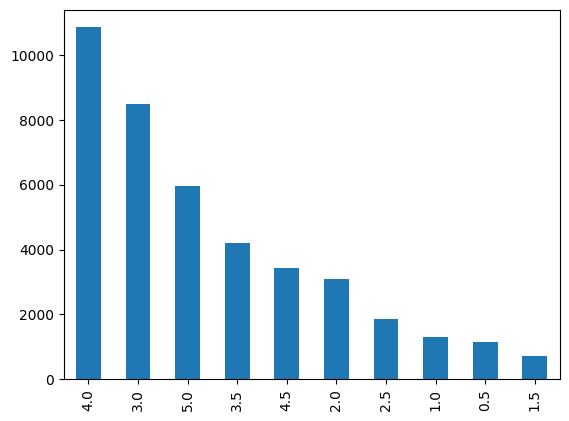

In [7]:
df.rating.value_counts().plot(kind = "bar")

### Mapping users and items

In [8]:
map_users = {user: u_id for u_id, user in enumerate(df.userId.unique())}
map_items = {item: i_id for i_id, item in enumerate(df.movieId.unique())}

df["movieId"] = df["movieId"].map(map_items)
df["userId"] = df["userId"].map(map_users)

In [9]:
df.head()

,userId,movieId,rating,title
0,0,0,3.5,Three Colors: Blue (Trois couleurs: Bleu)
1,0,1,3.5,Kalifornia
2,0,2,1.5,Weekend at Bernie's
3,0,3,4.5,Better Off Dead...
4,0,4,4.5,Waiting for Guffman


In [10]:
movieId_title = {}

for idx, row in df.iterrows():
    movieId_title[row["movieId"]] = row["title"]
    
np.save('map_title.npy', movieId_title)

### Split Dataset 

In [11]:
train, test = train_test_split(df, test_size = 0.33, random_state = 56)
train.to_csv("train.dat", index=False, header=False, sep='\t', encoding="CP1250", errors="ignore")
test.to_csv("test.dat", index=False, header=False, sep='\t', encoding="CP1250", errors="ignore")

### Train and predict

#### UserKNN

In [12]:
from caserec.recommenders.item_recommendation.userknn import UserKNN

UserKNN("train.dat", "test.dat", "rank_userknn.dat", as_binary=True).compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > UserKNN Algorithm]

train data:: 397 users and 5884 items (27519 interactions) | sparsity:: 98.82%
test data:: 376 users and 4280 items (13555 interactions) | sparsity:: 99.16%

training_time:: 0.535144 sec
prediction_time:: 5.638905 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.276596	0.466958	0.467289	0.455042	


In [13]:
ranking = pd.read_csv('rank_userknn.dat', sep='\t', names=["userId", "movieId", "rating"])
ranking['title'] = ranking.movieId.map(movieId_title)
ranking.head(5)

,userId,movieId,rating,title
0,0,165,0.491441,"Silence of the Lambs, The"
1,0,162,0.394857,Terminator 2: Judgment Day
2,0,216,0.341035,Raiders of the Lost Ark (Indiana Jones and the...
3,0,83,0.339503,Die Hard: With a Vengeance
4,0,108,0.320280,Stargate


In [14]:
ranking.loc[ranking.userId == 55]

,userId,movieId,rating,title
540,55,215,4.021060,Star Wars: Episode V - The Empire Strikes Back
541,55,165,3.543657,"Silence of the Lambs, The"
542,55,106,3.481800,Pulp Fiction
543,55,345,3.356945,Edward Scissorhands
544,55,284,3.286520,Good Will Hunting
545,55,62,3.253513,"Usual Suspects, The"
546,55,110,3.143788,"Shawshank Redemption, The"
547,55,221,3.106300,Star Wars: Episode VI - Return of the Jedi
548,55,390,3.102171,"Blair Witch Project, The"
549,55,491,3.088010,X-Men


#### ItemKNN

In [15]:
from caserec.recommenders.item_recommendation.itemknn import ItemKNN

ItemKNN("train.dat", "test.dat", "rank_itemknn.dat", as_binary=True).compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > ItemKNN Algorithm]

train data:: 397 users and 5884 items (27519 interactions) | sparsity:: 98.82%
test data:: 376 users and 4280 items (13555 interactions) | sparsity:: 99.16%

training_time:: 25.711412 sec
prediction_time:: 39.664721 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.303191	0.43373	0.440824	0.431239	


In [16]:
ranking = pd.read_csv('rank_itemknn.dat', sep='\t', names=["userId", "movieId", "rating"])
ranking['title'] = ranking.movieId.map(movieId_title)
ranking.head(5)

,userId,movieId,rating,title
0,0,714,1.113408,Blade: Trinity
1,0,261,1.064443,Batman & Robin
2,0,1300,1.047746,Darby O'Gill and the Little People
3,0,483,1.045785,Mad Max Beyond Thunderdome
4,0,8,0.962910,¡Three Amigos!


In [17]:
ranking.loc[ranking.userId == 55]

,userId,movieId,rating,title
540,55,215,20.967005,Star Wars: Episode V - The Empire Strikes Back
541,55,222,18.225778,Alien
542,55,221,17.397059,Star Wars: Episode VI - Return of the Jedi
543,55,110,17.130805,"Shawshank Redemption, The"
544,55,165,15.618288,"Silence of the Lambs, The"
545,55,161,15.028443,Aladdin
546,55,73,14.826518,Braveheart
547,55,106,14.775541,Pulp Fiction
548,55,284,14.640038,Good Will Hunting
549,55,62,14.498251,"Usual Suspects, The"


#### Most Popular items (Non-Personalized Recommendation)

In [18]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular

MostPopular("train.dat", "test.dat", "rank_mostPopular.dat").compute(as_table=True, metrics=['NDCG'])

[Case Recommender: Item Recommendation > Most Popular]

train data:: 397 users and 5884 items (27519 interactions) | sparsity:: 98.82%
test data:: 376 users and 4280 items (13555 interactions) | sparsity:: 99.16%

prediction_time:: 4.381925 sec


NDCG@1	NDCG@3	NDCG@5	NDCG@10	
0.207447	0.3519	0.359983	0.370887	


In [19]:
ranking = pd.read_csv('rank_mostPopular.dat', sep='\t', names=["userId", "movieId", "rating"])
ranking['title'] = ranking.movieId.map(movieId_title)
ranking.head(5)

,userId,movieId,rating,title
0,0,110,403.5,"Shawshank Redemption, The"
1,0,106,338.0,Pulp Fiction
2,0,376,335.5,"Matrix, The"
3,0,121,326.5,Forrest Gump
4,0,165,323.0,"Silence of the Lambs, The"


In [20]:
ranking.loc[ranking.userId == 55]

,userId,movieId,rating,title
540,55,110,403.5,"Shawshank Redemption, The"
541,55,106,338.0,Pulp Fiction
542,55,165,323.0,"Silence of the Lambs, The"
543,55,62,265.5,"Usual Suspects, The"
544,55,73,264.5,Braveheart
545,55,215,238.0,Star Wars: Episode V - The Empire Strikes Back
546,55,221,224.5,Star Wars: Episode VI - Return of the Jedi
547,55,410,220.5,American Beauty
548,55,168,218.0,Fargo
549,55,142,212.0,"Fugitive, The"
